#Get data from VPS

In [1]:
#Data handling
import numpy as np
import pandas as pd
import simplejson as json

#Server
import urllib2

#Timestamp handling
from datetime import datetime

#GUI
import Tkinter as tk

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import dates as mdates
from matplotlib.ticker import LinearLocator

##Selection of server data

In [85]:
class server_GUI(tk.Frame):
    def __init__(self, parent, *args, **kwargs):
        tk.Frame.__init__(self, parent, *args, **kwargs)
        self.grid()
        self.parent = parent
        
        self.link = ""
        self.initial_values = ['100000','10000','53ff6d066667574831402467']
        self.devices = ['53ff6d066667574831402467','test','test2','test3']
        
        self.var = [tk.StringVar(self.parent) for i in range(3)]
        [self.var[i].set(self.initial_values[i]) for i in range(3)]
        
    def select_stuff(self):
        
        tk.Label(self.parent, text="Select start row:").grid(row=0,column=0)
        tk.Entry(self.parent, textvariable=self.var[0]).grid(row=1,column=0)
        
        tk.Label(self.parent, text="Select number of rows:").grid(row=0,column=1)
        tk.Entry(self.parent, textvariable=self.var[1]).grid(row=1,column=1)
        
        tk.Label(self.parent, text="Select device:").grid(row=0,column=2)
        apply(tk.OptionMenu, (self.parent, self.var[2]) + tuple(self.devices)).grid(row=1,column=2)
        
        tk.Button(self.parent, text='OK', command=self.ok).grid(row=4,column=5)
        
    def ok(self):
        try:
            print "The start row is {},\n the number of rows is {},\n the device number is {}.\n".format(self.var[0].get(),self.var[1].get(),self.var[2].get())
            
            self.link = "http://109.237.25.161/particle/events?start={}&num_rows={}&device={}".format(self.var[0].get(),self.var[1].get(),self.var[2].get())
            
            print "Created link {}\n".format(self.link)
            
            self.parent.quit()
        
        except:
            print "Please try again!"

root = tk.Tk()
root.title('Select data to be fetched')

App = server_GUI(root)
App.select_stuff()

root.mainloop()
root.destroy()

The start row is 90000,
 the number of rows is 100000,
 the device number is 53ff6d066667574831402467.

Created link http://109.237.25.161/particle/events?start=90000&num_rows=100000&device=53ff6d066667574831402467



In [86]:
decoded_json = json.loads(urllib2.urlopen(App.link).read())['events']

date_format = '%Y-%m-%d %H:%M:%S'
dat = []
timestamp = []

for line in decoded_json:
    buf = [x.strip() for x in line['data'].split(",")]
    
    if len(buf)==5:
            dat.append(buf)
            timestamp.append(datetime.strptime(line['timestamp'],date_format))
    elif len(buf)==2:
            try:
                dat[-1].append(buf[0])
                dat[-1].append(buf[1])
            except IndexError:
                continue
    else:
            continue

print "Data has been fetched.\n"

Data has been fetched.



In [87]:
params = ["temp","light","noise_max","noise_av","noise_var","pir_per","pir_num"]

df = pd.DataFrame(dat, index=timestamp, columns=params)
df = df.convert_objects(convert_numeric=True)

print "Data has been added to a pandas dataframe:\n"
print df.describe()

Data has been added to a pandas dataframe:

               temp         light     noise_max      noise_av     noise_var  \
count  48208.000000  48208.000000  48208.000000  48208.000000  48208.000000   
mean      29.627132   1660.628319   2095.084322   2068.897254     63.897558   
std        0.954391   1226.455288     45.471298      0.536931    820.398738   
min       27.700000    344.000000   2072.000000   2054.500000      1.700000   
25%       28.900000    457.000000   2077.000000   2068.700000      3.400000   
50%       29.600000   1240.000000   2086.000000   2068.900000      5.400000   
75%       30.400000   3081.000000   2099.000000   2069.100000     13.900000   
max       32.400000   3380.000000   3298.000000   2087.800000  66404.300000   

            pir_per       pir_num  
count  48164.000000  48164.000000  
mean       2.523715      5.495432  
std       11.052538     22.820131  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.0

##Plot fetched data:

Plots of raw data:



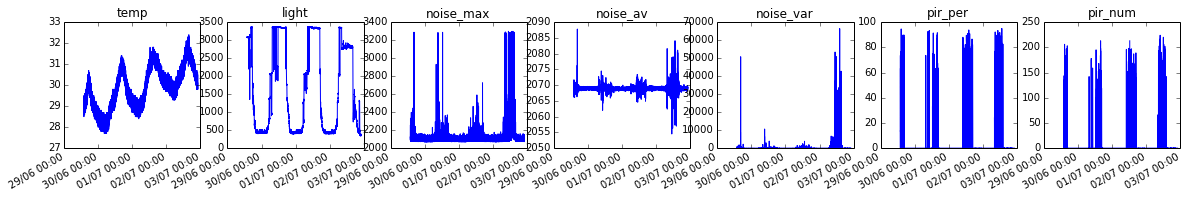

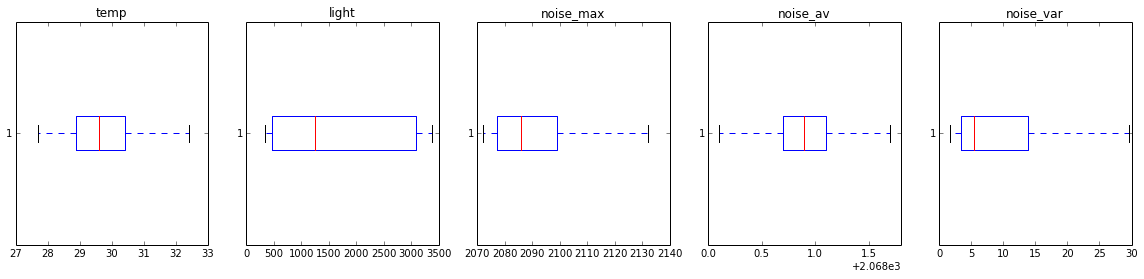

In [88]:
#PLOT
hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig, axs = plt.subplots(1,len(params), sharex=True, figsize=(20,2.5))

print "Plots of raw data:\n"

for i in range(len(params)):
    para = params[i]
    axs[i].plot(df[para].index,df[para].values)
    axs[i].set_title(para)
    axs[i].xaxis.set_major_formatter(hfmt)
    axs[i].xaxis.set_major_locator(LinearLocator(numticks=5))

fig.autofmt_xdate()

fig, axs = plt.subplots(1,len(params)-2, sharex=False, figsize=(20,4))

for i in range(len(params)-2):
    para = params[i]
    axs[i].boxplot(df[para].values,0,'',0)
    axs[i].set_title(para)

##Filtering:

The signals are being Gauss filterd:



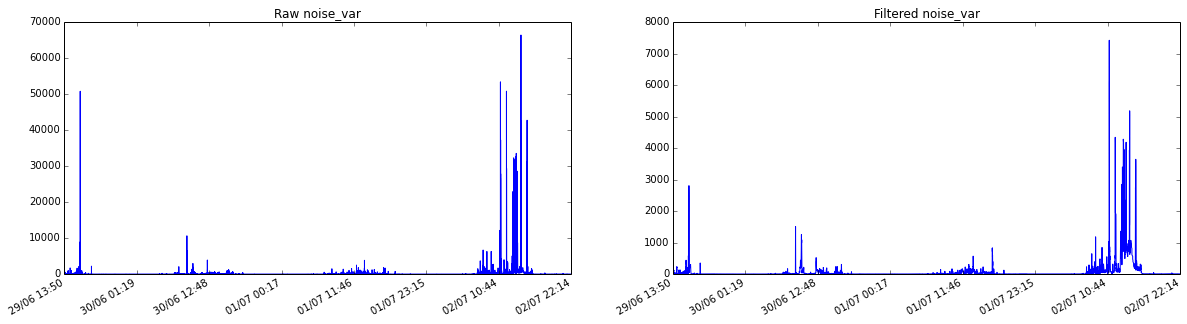

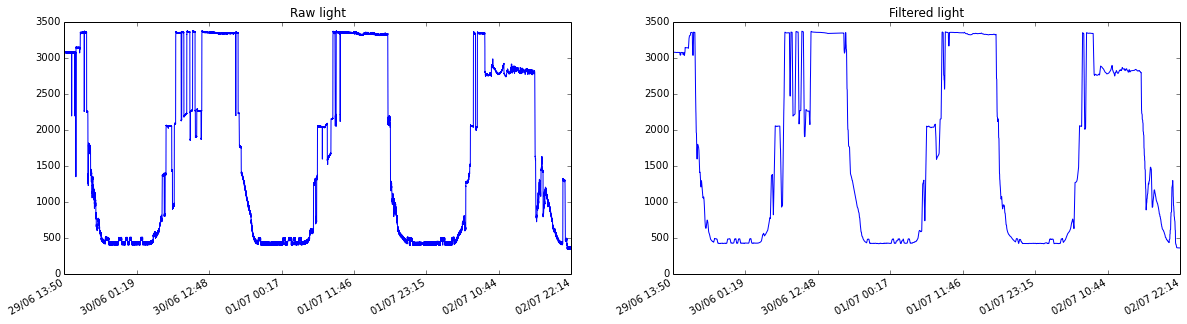

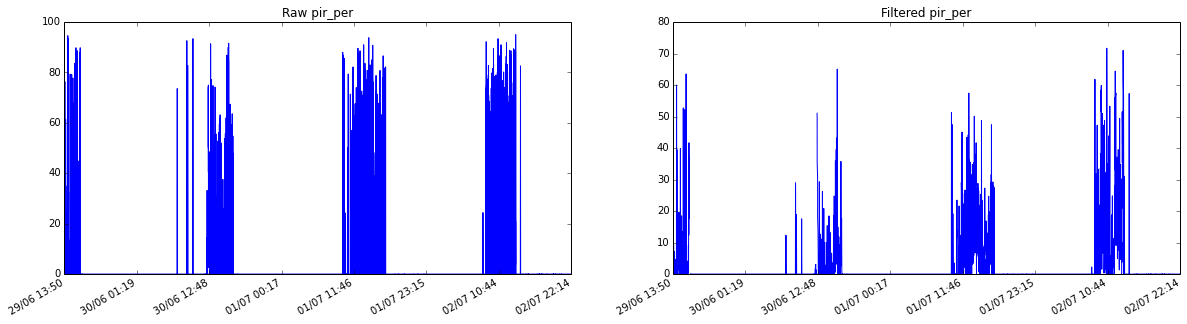

In [89]:
from scipy.signal import gaussian
from scipy.ndimage import filters

def Gauss_filt(y, M, std):
    b = gaussian(M, std)
    ga = filters.convolve1d(y, b/b.sum())
    return ga

para = ["noise_var","light","pir_per"]
filt_params = np.array([[20,15],[100,60],[15,5]], dtype=int)
filt_sig = np.zeros((df.count()[0],len(para)))

print "The signals are being Gauss filterd:\n"

for i in range(len(para)):
    
    filt_sig[:,i] = Gauss_filt(df[para[i]].values,filt_params[i,0],filt_params[i,1])

    fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20,5))
    hfmt = mdates.DateFormatter('%d/%m %H:%M')

    axs[0].plot(df[para[i]].index,df[para[i]].values)
    axs[1].plot(df[para[i]].index,filt_sig[:,i])

    axs[0].set_title("Raw {}".format(para[i]))
    axs[1].set_title("Filtered {}".format(para[i]))

    for i in range(2):
        axs[i].xaxis.set_major_formatter(hfmt)
        axs[i].xaxis.set_major_locator(LinearLocator(numticks=8))

    fig.autofmt_xdate()


##Normalise signals

For this selection, the min is 2.30302599633 and the max is 7422.44563997 (noise_var)
For this selection, the min is 361.917970551 and the max is 3372.74912861 (light)
For this selection, the min is 0.0 and the max is 71.6926978503 (pir_per)


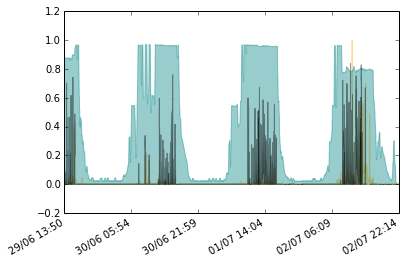

In [90]:
norm_sig = np.zeros(filt_sig.shape,dtype=float)
cols = ['orange','teal','black']
#mins and max from whole database as of 20 July (for normalisation):
min_max = np.array([[2.30302599633,7422.44563997],[362.349324163,3460.20613676],[0.0,85.4879737739]]) 

fig, ax = plt.subplots()

#para = ["noise_var","light","pir_per"]
for i in range(len(para)):
    #norm_sig[:,i] = (filt_sig[:,i]-np.nanmin(filt_sig[:,i]))/(np.nanmax(filt_sig[:,i])-np.nanmin(filt_sig[:,i]))
    norm_sig[:,i] = (filt_sig[:,i]-min_max[i,0])/(min_max[i,1]-min_max[i,0])
    print "For this selection, the min is {1} and the max is {2} ({0})".format(para[i], np.nanmin(filt_sig[:,i]), np.nanmax(filt_sig[:,i]))
    ax.fill_between(df.index,0,norm_sig[:,i],color=cols[i],alpha=.4)

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
ax.xaxis.set_major_locator(LinearLocator(numticks=6))
ax.xaxis.set_major_formatter(hfmt)

##Infere some stuff:

(0, 1)

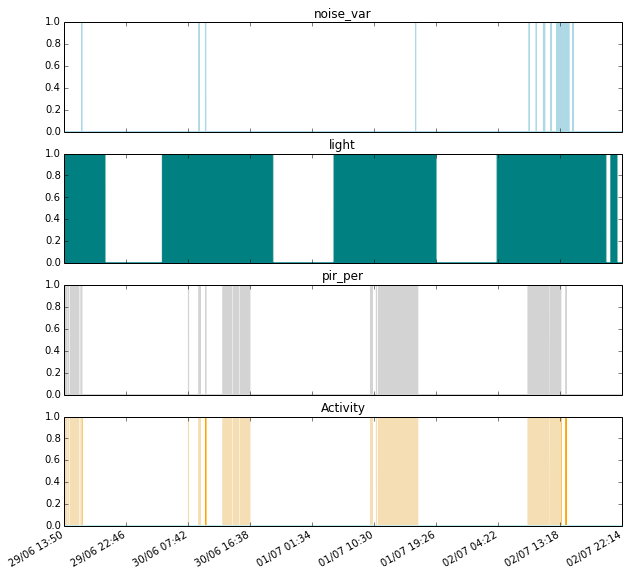

In [91]:
treshold = np.array([.1,.05,.05])
lines = np.zeros(filt_sig.shape, dtype=int)

#para = ["noise_var","light","pir_per"]
for i in range(len(para)):
    lines[:,i] = [1 if x>treshold[i] else 0 for x in norm_sig[:,i]]

day_active_high = [1 if (x==1 and y==1 and z==1) else 0 for (x,y,z) in lines]
day_active_low = [1 if (x==0 and y==1 and z==1) else 0 for (x,y,z) in lines]
night_active_high = [1 if (x==1 and y==0 and z==1) else 0 for (x,y,z) in lines]
night_active_low = [1 if (x==0 and y==0 and z==1) else 0 for (x,y,z) in lines]

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10,10))
cols = ['lightblue','teal','lightgray']

for i in range(3):
    axs[i].fill_between(df.index,0,lines[:,i],color=cols[i])
    axs[i].set_title("{}".format(para[i]))
    
axs[3].fill_between(df.index,0,day_active_high,color="orange")
axs[3].fill_between(df.index,0,day_active_low,color="wheat")
axs[3].fill_between(df.index,0,night_active_high,color="darkcyan")
axs[3].fill_between(df.index,0,night_active_low,color="lightcyan")

axs[3].set_title("Activity")

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
axs[0].xaxis.set_major_formatter(hfmt)
axs[0].set_ylim(0,1)